In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cobra
import os
os.getcwd()

from src.no_BayesianInference import BMCA, util

Generating data for running through the pipeline.

Running BMCA on BioModel 64

In [2]:
# load the Teusink model
Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
data_file = 'data/interim/generated_data/BIOMD0000000064_e_0.csv'
data = pd.read_csv(data_file)

Comparing flux values, original and perturbed

In [4]:
_ = data.transpose().sort_index()
# _.rename({0: "unperturbed ss", 1: "EtOH -50%"}, axis=1, inplace=True)
_.loc['v_':'v_z']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
v_vADH,129.215909,126.074232,131.301487,129.175587,129.247051,130.624826,127.775393,130.313187,128.103523,129.184641,129.239383,129.209453,129.220942,128.353801,129.991105,129.190077,129.237081,129.194725,129.233139,129.154919,129.260850,129.185544,129.239248,129.190999,129.227699,130.431801,128.075222,113.207883,144.801531,128.810086,129.552723,131.153060,127.328554,130.331846,127.912646,129.215909,129.215909,129.215909,129.215909,129.215909,129.215909,129.215909,129.215909,128.768847,129.583231,130.334496,128.162364,129.117064,129.313707,129.197643,129.231392
v_vALD,77.349527,75.631215,78.491249,77.327463,77.366568,78.130239,76.553521,77.955666,76.736059,77.332417,77.362372,77.345994,77.352281,77.223640,77.458585,77.345827,77.352556,77.346493,77.351993,77.340784,77.355954,77.345177,77.352866,77.345959,77.351214,77.508743,77.193025,68.598840,85.931217,77.294658,77.394400,77.598212,77.087700,78.050919,76.591666,77.349527,77.349527,77.349527,77.349527,77.349527,77.349527,77.349527,77.349527,77.104912,77.550541,77.496281,77.205232,77.336306,77.362556,77.339532,77.357999
v_vATP,84.532764,81.686034,86.420476,84.496249,84.560966,86.989173,82.043744,86.235042,82.814929,84.504448,84.554022,84.526918,84.537322,83.060322,85.865039,84.488501,84.569049,84.496464,84.562294,84.428270,84.609791,84.480734,84.572763,84.490080,84.552969,86.646117,82.564395,70.018086,98.540628,83.830855,85.116646,87.909697,81.281710,85.361854,83.441960,84.532764,84.532764,84.532764,84.532764,84.532764,84.532764,84.532764,84.532764,84.127871,84.865379,86.476431,82.714263,84.361517,84.702302,84.516223,84.546785
v_vENO,136.496807,133.270860,138.638919,136.455398,136.528790,137.949298,135.013006,137.626943,135.351693,136.464696,136.520915,136.490178,136.501976,135.809081,137.112838,136.476242,136.513662,136.479942,136.510524,136.448247,136.532581,136.472632,136.515386,136.476975,136.506193,137.456283,135.592602,120.062110,152.533217,136.175580,136.763031,138.022593,134.999081,137.694701,135.132842,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.037698,136.874045,137.379658,135.661821,136.418649,136.574109,136.478049,136.512708
v_vG3PDH,18.202246,17.991570,18.343579,18.199527,18.204347,18.311181,18.094035,18.284389,18.120425,18.200138,18.203829,18.201811,18.202586,18.638199,17.804333,18.215412,18.191451,18.213043,18.193461,18.233320,18.179327,18.217721,18.190346,18.214942,18.196236,17.561203,18.793448,17.135569,19.329216,18.413736,18.025770,17.173831,19.176318,18.407137,18.050490,18.202246,18.202246,18.202246,18.202246,18.202246,18.202246,18.202246,18.202246,18.172126,18.227037,17.612904,18.748643,18.253962,18.151004,18.201015,18.203290
v_vGAPDH,136.496807,133.270860,138.638919,136.455398,136.528790,137.949298,135.013006,137.626943,135.351693,136.464696,136.520915,136.490178,136.501976,135.809081,137.112838,136.476242,136.513662,136.479942,136.510524,136.448247,136.532581,136.472632,136.515386,136.476975,136.506193,137.456283,135.592602,120.062110,152.533217,136.175580,136.763031,138.022593,134.999081,137.694701,135.132842,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.037698,136.874045,137.379658,135.661821,136.418649,136.574109,136.478049,136.512708
v_vGLK,88.149527,86.431215,89.291249,88.127463,88.166568,88.330239,87.953521,88.275666,88.016059,88.132417,88.162372,88.145994,88.152281,88.023640,88.258585,88.145827,88.152556,88.146493,88.151993,88.140784,88.155954,88.145177,88.152866,88.145959,88.151214,88.308743,87.993025,79.398840,96.731217,88.094658,88.194400,88.398212,87.887700,88.850919,87.391666,88.149527,88.149527,88.149527,88.149527,88.149527,88.149527,88.149527,88.149527,87.904912,88.350541,88.296281,88.005232,88.136306,88.162556,88.139532,88.157999
v_vGLT,88.149527,86.431215,89.291249,88.127463,88.166568,88.330239,87.953521,88.

Calculating the steady state concentrations of the Teusink model when EtOH concentration is halved. 

Predicting the steady state concentration values 

In [ ]:
r = te.loada(Teusink_ant)
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file, desired_product='ETOH')
chi = BIOMD64.calculate_Smallbone_ss(BIOMD64.Ex, BIOMD64.Ey)
print(np.exp(chi.to_numpy()))

In [8]:
x_ss = np.exp(chi_star.to_numpy())
a = s.getIndependentFloatingSpeciesIds()
b = s.getFloatingSpeciesIds()
squiggle_idx = [b.index(i) for i in a if i in b]
squiggle_idx.sort()
estimated_ss = pd.DataFrame(data=x_ss, index=[b[i] for i in squiggle_idx], columns=['estimated'])

In [9]:
comparison = pd.concat([true_ss_values, estimated_ss], axis = 1)
comparison['error (%)'] = (comparison['estimated'])/comparison['true']
comparison.sort_index()

,true,estimated,error (%)
ACE,0.170114,0.189530,1.114133
BPG,0.000330,0.015044,45.647210
F16P,0.601908,0.008905,0.014795
F6P,0.112813,0.037363,0.331192
G6P,1.033246,0.037087,0.035894
GLCi,0.098759,0.395924,4.009007
NAD,1.545560,19.125750,12.374643
NADH,0.044440,NaN,NaN
P,6.308882,0.236591,0.037501
P2G,0.044844,0.055296,1.233077


Plotting relative changes in EtOH by relative changes in steady state intracelluar metabolite concentrations (Figure 3 in Smallbone et al. )

In [36]:
EtOH_scale = np.logspace(-1, 1, num=22)[:-2]
EtOH_scale

array([0.1       , 0.12451971, 0.15505158, 0.19306977, 0.24040992,
       0.29935773, 0.37275937, 0.46415888, 0.57796929, 0.71968567,
       0.8961505 , 1.11588399, 1.38949549, 1.73019574, 2.15443469,
       2.6826958 , 3.34048498, 4.15956216, 5.17947468, 6.44946677])

In [47]:
def calculate_relative_change(metabolite): 
    metabolite_scale = []

    for change in EtOH_scale: 
        s.resetAll()
        s.ETOH =(change * s.ETOH)
        # print(s.ETOH)
        s.steadyState()
        
        #s.simulate(0,50)
        #s.plot(title=change)
        
        metabolite_scale.append(s.getValue(metabolite))

    # calculate the relative change in BPG
    s.resetAll()
    s.steadyState()
    met_ss = s.getValue(metabolite)
    met_scale = np.array(metabolite_scale) / met_ss

    return met_scale

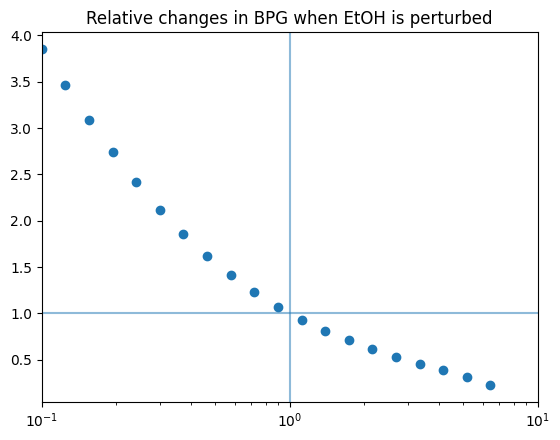

In [140]:
plt.scatter(EtOH_scale, calculate_relative_change('BPG'))
plt.xscale('log', base=10)
plt.xlim(0.1, 10)
plt.title('Relative changes in BPG when EtOH is perturbed')
plt.axvline(1, alpha=0.5)
plt.axhline(1, alpha=0.5)

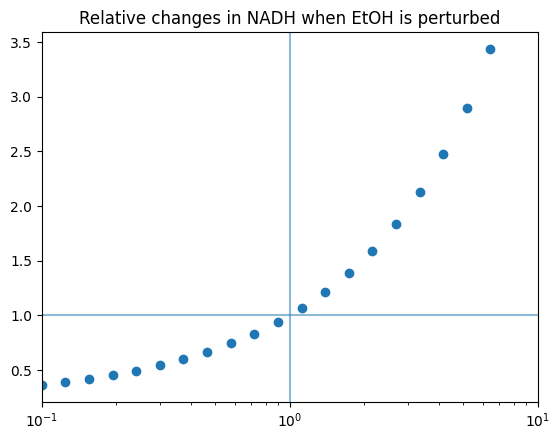

In [141]:
plt.scatter(EtOH_scale, calculate_relative_change('NADH'))
plt.xscale('log', base=10)
plt.xlim(0.1, 10)
plt.title('Relative changes in NADH when EtOH is perturbed')
plt.axvline(1, alpha=0.5)
plt.axhline(1, alpha=0.5)

Plotting relative changes in EtOH by relative changes in steady state fluxes *when fully parameterized*

In [3]:
ETOH_data_file = 'data/interim/generated_data/EtOHcompilation.csv'
ETOH_data = pd.read_csv(ETOH_data_file)

Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
r = te.loada(Teusink_ant)
BIOMD64 = BMCA.BMCA(Teusink_ant, ETOH_data_file)
r.steadyState()
Ex = r.getUnscaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))

In [4]:
EtOH_scale = np.logspace(-2, 1, num=22)[:-7]
EtOH_scale = EtOH_scale * 100
a = ETOH_data['ETOH']/50
a.drop(a.index[0],inplace=True)

EtOH_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + Ex@np.log(BIOMD64.xn).T + Ey@np.log(BIOMD64.yn).T)

EtOH_perturbed_fluxes_df = pd.DataFrame(EtOH_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
EtOH_perturbed_fluxes_df

,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,-6.954164e+03,-4.643389e+03,-3.183930e+03,-2.208053e+03,-1.537029e+03,-1.068260e+03,-7.375859e+02,-5.028580e+02,-3.355407e+02,-2.159342e+02,-1.302653e+02,-6.881996e+01,-2.470550e+01,6.988099e+00,88.149527,1.690138e+02,2.004305e+02,2.440102e+02,3.044240e+02,3.880996e+02,5.038565e+02,6.637347e+02,8.840730e+02,1.186869e+03,1.601445e+03,2.166437e+03,2.932110e+03,3.963145e+03,5.342388e+03,7.177124e+03
vPGI,-1.848798e+04,-1.128821e+04,-7.368629e+03,-4.970149e+03,-3.413354e+03,-2.367366e+03,-1.649104e+03,-1.148756e+03,-7.968081e+02,-5.475802e+02,-3.702647e+02,-2.436958e+02,-1.531384e+02,-8.823884e+01,77.349527,2.414668e+02,3.049968e+02,3.929100e+02,5.143730e+02,6.818263e+02,9.120011e+02,1.227116e+03,1.656168e+03,2.236108e+03,3.012487e+03,4.038960e+03,5.374866e+03,7.080294e+03,9.208954e+03,1.180111e+04
vGLYCO,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00
vTreha,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00,2.400000e+00
vPFK,2.698347e+04,1.648893e+04,1.080293e+04,7.336316e+03,5.091976e+03,3.586717e+03,2.554366e+03,1.835852e+03,1.330756e+03,9.732366e+02,7.189561e+02,5.374899e+02,4.076756e+02,3.146526e+02,77.349527,-1.577873e+02,-2.487936e+02,-3.747141e+02,-5.486617e+02,-7.884196e+02,-1.117882e+03,-1.568737e+03,-2.182260e+03,-3.010898e+03,-4.119039e+03,-5.582056e+03,-7.482487e+03,-9.902547e+03,-1.291349e+04,-1.656521e+04
vALD,8.610233e+02,5.271401e+02,3.670865e+02,2.727912e+02,2.123581e+02,1.719149e+02,1.441646e+02,1.248265e+02,1.112146e+02,1.015688e+02,9.470207e+01,8.979821e+01,8.628831e+01,8.377216e+01,77.349527,7.097971e+01,6.851272e+01,6.509774e+01,6.037723e+01,5.386468e+01,4.490349e+01,3.261628e+01,1.584690e+01,-6.901967e+00,-3.752861e+01,-7.838181e+01,-1.323015e+02,-2.026772e+02,-2.936148e+02,-4.104348e+02
vGAPDH,-3.599479e+06,-2.093578e+06,-1.343934e+06,-9.018560e+05,-6.201464e+05,-4.328110e+05,-3.049503e+05,-2.162161e+05,-1.539638e+05,-1.099635e+05,-7.869142e+04,-5.637800e+04,-4.043341e+04,-2.900425e+04,136.496807,2.899217e+04,4.016511e+04,5.559879e+04,7.692342e+04,1.063133e+05,1.466618e+05,2.018539e+05,2.768750e+05,3.780931e+05,5.133212e+05,6.916841e+05,9.233122e+05,1.218643e+06,1.587500e+06,2.038433e+06
vPGK,1.271676e+08,7.398888e+07,4.750463e+07,3.188269e+07,2.192635e+07,1.530483e+07,1.078521e+07,7.648518e+06,5.447870e+06,3.892407e+06,2.786888e+06,1.998066e+06,1.434388e+06,1.030340e+06,136.496807,-1.020000e+06,-1.414999e+06,-1.960636e+06,-2.714542e+06,-3.753592e+06,-5.180096e+06,-7.131417e+06,-9.783860e+06,-1.336264e+07,-1.814410e+07,-2.445109e+07,-3.264209e+07,-4.308663e+07,-5.613261e+07,-7.208290e+07
vPGM,-2.971783e+05,-1.671669e+05,-1.057052e+05,-7.033292e+04,-4.809554e+04,-3.342721e+04,-2.346819e+04,-1.658101e+04,-1.175989e+04,-8.357082e+03,-5.941592e+03,-4.220126e+03,-2.989823e+03,-2.108791e+03,136.496807,2.358216e+03,3.217295e+03,4.405217e+03,6.044879e+03,8.302285e+03,1.139960e+04,1.562964e+04,2.137089e+04,2.909988e+04,3.939539e+04,5.292848e+04,7.043160e+04,9.264860e+04,1.202804e+05,1.539671e+05
vENO,7.164282e+04,3.999739e+04,2.529438e+04,1.687747e+04,1.159469e+04,8.111268e+03,5.746002e+03,4.109943e+03,2.964415e+03,2.155729e+03,1.581588e+03,1.172361e+03,8.798656e+02,6.703896e+02,136.496807,-3.918787e+02,-5.962101e

In [20]:
rel_EtOH_perturbed_fluxes_df = EtOH_perturbed_fluxes_df.div(EtOH_perturbed_fluxes_df[1.00], axis=0)
rel_EtOH_perturbed_fluxes_df

,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,-78.890548,-52.676279,-36.119653,-25.048951,-17.436615,-12.118728,-8.367440,-5.704603,-3.806495,-2.449635,-1.477777,-0.780718,-0.280268,0.079276,1.0,1.917354,2.273755,2.768139,3.453495,4.402741,5.715930,7.529645,10.029242,13.464265,18.167374,24.576842,33.262918,44.959349,60.605974,81.419877
vPGI,-239.018620,-145.937695,-95.264050,-64.255718,-44.128953,-30.606078,-21.320150,-14.851499,-10.301396,-7.079296,-4.786904,-3.150579,-1.979823,-1.140781,1.0,3.121761,3.943099,5.079669,6.649983,8.814873,11.790649,15.864552,21.411484,28.909137,38.946415,52.216997,69.488023,91.536355,119.056373,152.568572
vGLYCO,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vTreha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vPFK,348.851126,213.174327,139.663844,94.846291,65.830733,46.370257,33.023686,23.734495,17.204452,12.582321,9.294899,6.948845,5.270563,4.067932,1.0,-2.039926,-3.216485,-4.844426,-7.093278,-10.192947,-14.452349,-20.281144,-28.212970,-38.925868,-53.252285,-72.166650,-96.736039,-128.023365,-166.949869,-214.160521
vALD,11.131592,6.815040,4.745814,3.526734,2.745435,2.222572,1.863807,1.613798,1.437818,1.313114,1.224339,1.160941,1.115563,1.083034,1.0,0.917649,0.885755,0.841605,0.780577,0.696380,0.580527,0.421674,0.204874,-0.089231,-0.485182,-1.013346,-1.710438,-2.620277,-3.795948,-5.306236
vGAPDH,-26370.429887,-15337.926318,-9845.902010,-6607.158165,-4543.303393,-3170.850628,-2234.120070,-1584.038121,-1127.966108,-805.611956,-576.507432,-413.035289,-296.222389,-212.490291,1.0,212.401811,294.256778,407.326659,563.554731,778.870238,1074.470736,1478.817842,2028.435735,2769.977956,3760.683196,5067.401603,6764.350137,8927.996380,11630.307279,14933.924941
vPGK,931652.650860,542055.740829,348027.374883,233578.260953,160636.363473,112125.911076,79014.409088,56034.411097,39912.069559,28516.466073,20417.241127,14638.189466,10508.579372,7548.451412,1.0,-7472.704001,-10366.532398,-14363.968668,-19887.220318,-27499.486331,-37950.310286,-52246.034861,-71678.308405,-97897.076040,-132926.933018,-179133.023589,-239141.813276,-315660.378018,-411237.552485,-528092.225117
vPGM,-2177.181177,-1224.694557,-774.415334,-515.271551,-352.356527,-244.893707,-171.932146,-121.475478,-86.155060,-61.225476,-43.529162,-30.917401,-21.903978,-15.449378,1.0,17.276710,23.570481,32.273410,44.285866,60.824023,83.515482,114.505507,156.566943,213.190934,288.617698,387.763492,515.994503,678.760169,881.195514,1127.990171
vENO,524.868098,293.028024,185.311178,123.647375,84.944762,59.424602,42.096240,30.110175,21.717836,15.793256,11.586993,8.588928,6.446052,4.911394,1.0,-2.870974,-4.367942,-6.438099,-9.295827,-13.230822,-18.631189,-26.009110,-36.027978,-49.526095,-67.527693,-91.233391,-121.980009,-161.177867,-210.255355,-270.688268


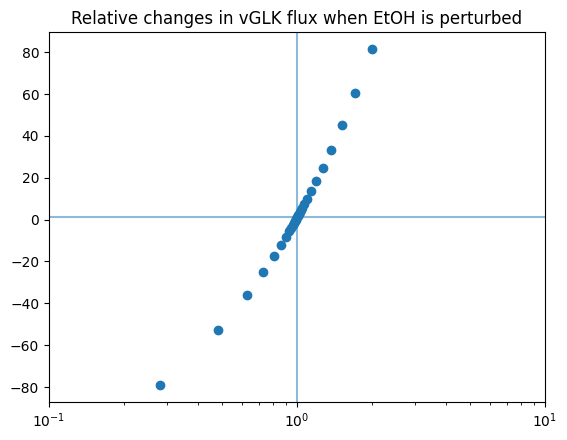

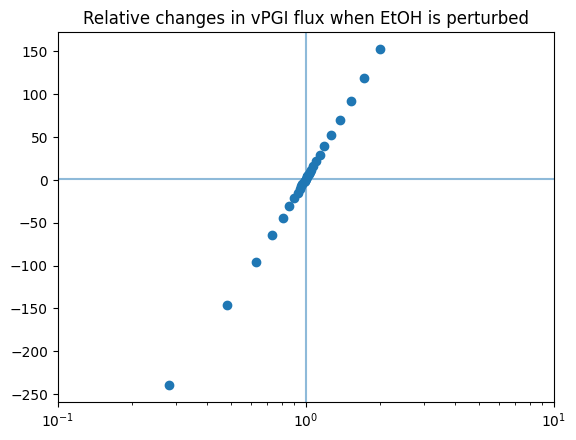

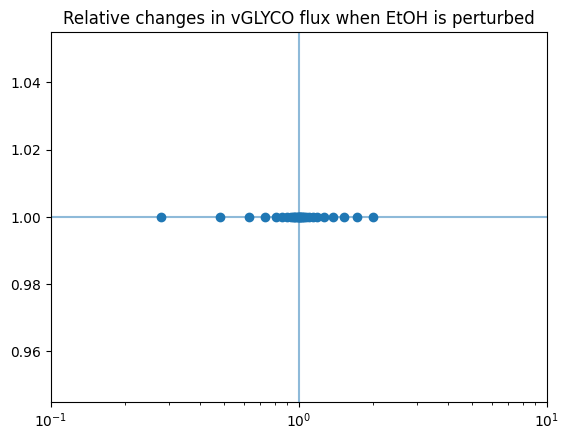

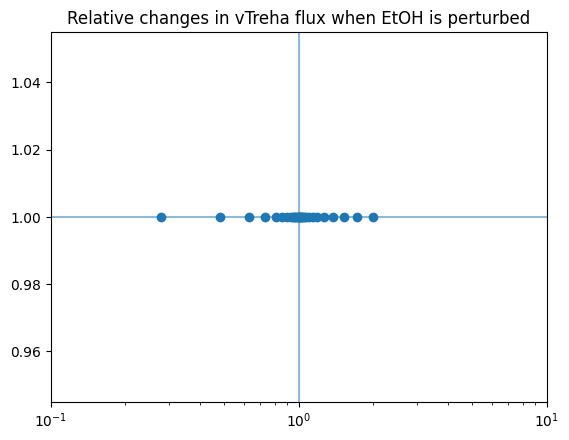

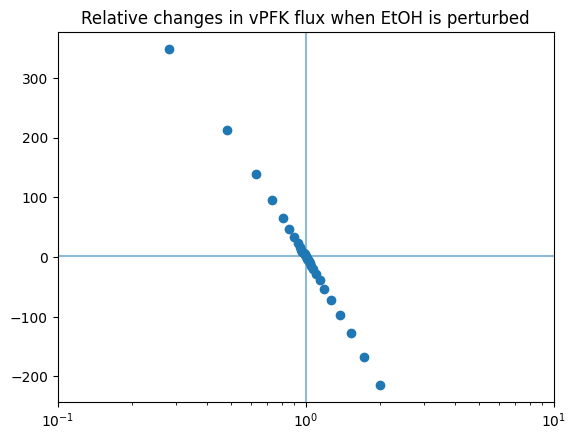

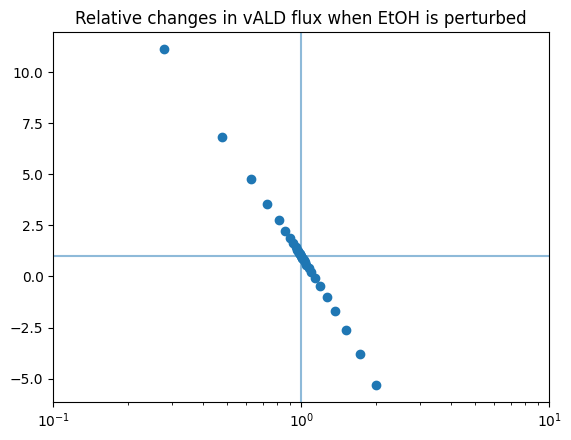

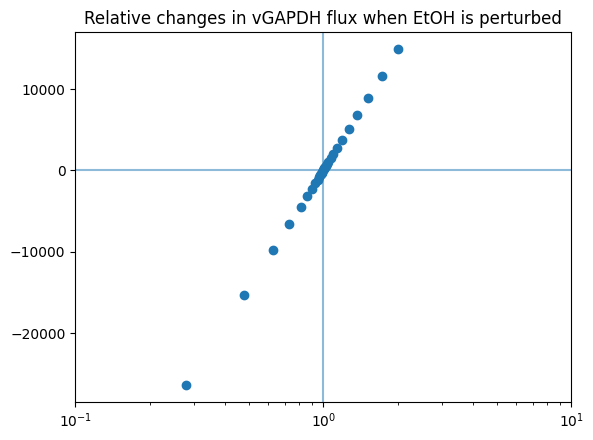

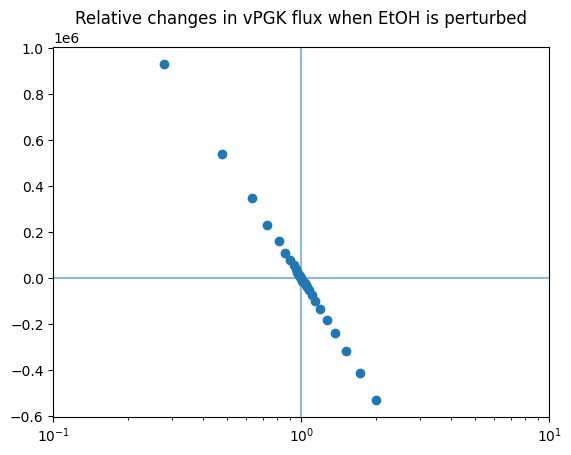

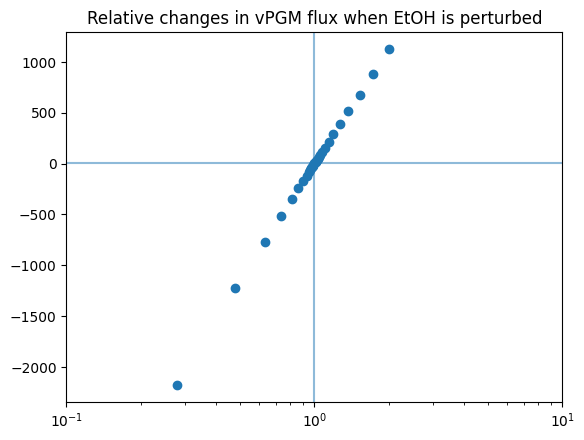

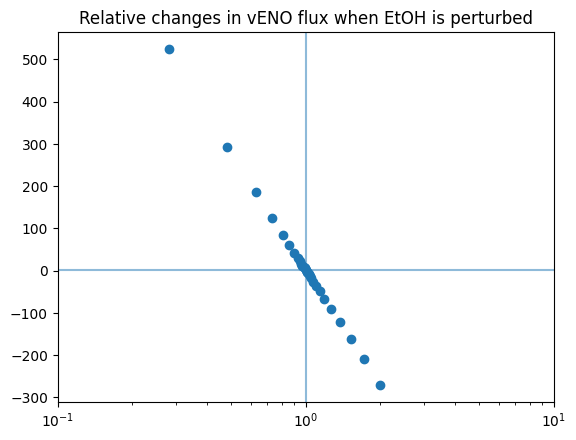

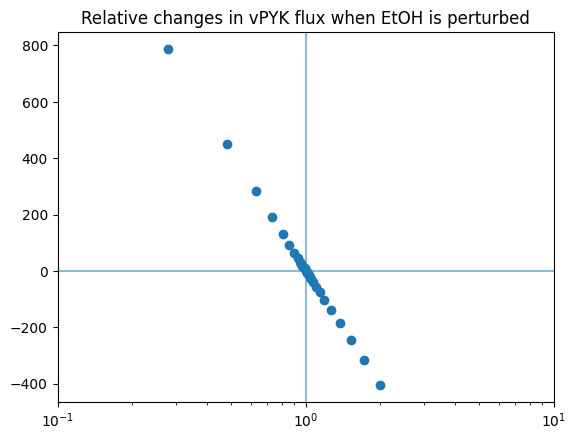

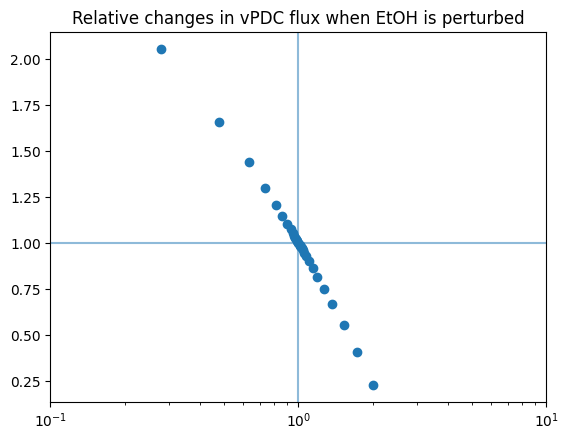

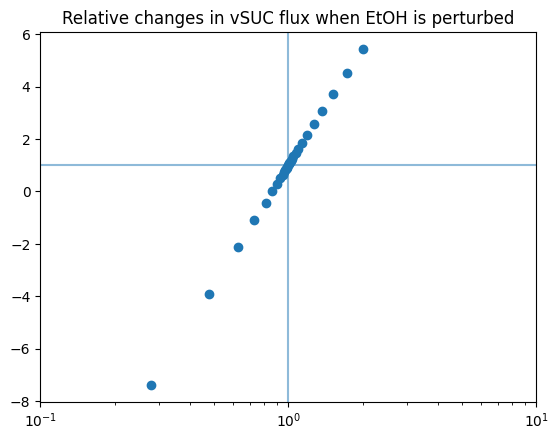

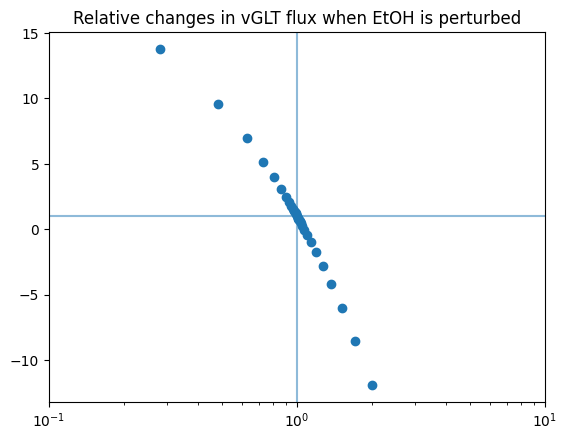

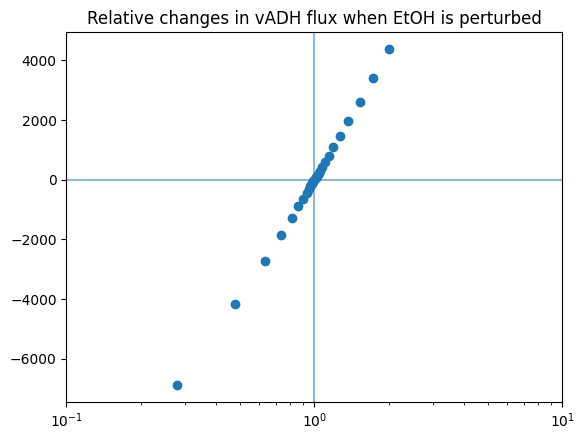

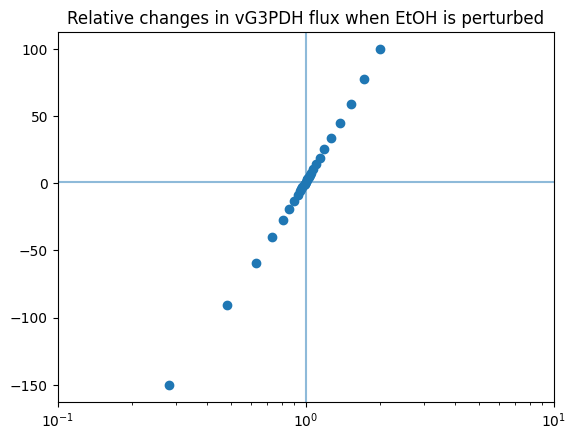

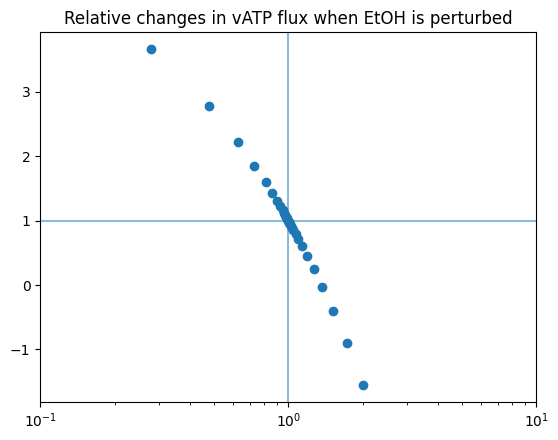

In [28]:


for rxn in r.getReactionIds():
    
    ## NEED TO PLOT THE REAL VALUES HERE TOO
    
    plt.scatter(rel_EtOH_perturbed_fluxes_df.columns, rel_EtOH_perturbed_fluxes_df.loc[rxn])
    plt.xscale('log', base=10)
    plt.xlim(0.1, 10)
    plt.title(f'Relative changes in {rxn} flux when EtOH is perturbed')
    plt.axvline(1, alpha=0.5)
    plt.axhline(1, alpha=0.5)
    plt.show()